# COVID-19 Prediction Analysis

In [2]:
# Suppress warning messages
import warnings 
warnings.filterwarnings('ignore')

In [3]:
# Import general dependencies
import os 
import pandas as pd
from pprint import pprint
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import datetime

In [6]:
#Import connection dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import psycopg2

In [9]:
# Import machine learning dependencies 
import sklearn as skl
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# from sklearn.metrics import accuracy_score, confusion_matrix
# from imblearn.metrics import classificationn_report_imbalanced 
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

# import keras_tuner as kt

### Data Source

**Our World in Data COVID-19 Dataset Citation**
Hannah Ritchie, Edouard Mathieu, Lucas Rodés-Guirao, Cameron Appel, Charlie Giattino, Esteban Ortiz-Ospina, Joe Hasell, Bobbie Macdonald, Diana Beltekian and Max Roser (2020) - "Coronavirus Pandemic (COVID-19)". Published online at OurWorldInData.org. Retrieved from: [Our World In Data / Coronavirus](https://ourworldindata.org/coronavirus)

In [10]:
# Create connection to SQL database
conn = psycopg2.connect(
    host="finalproject.cjgqtjwgyywe.us-east-2.rds.amazonaws.com",
    database="postgres",
    user="postgres",
    password="FinalProject1")

In [11]:
# Read the OneWorldInData COVID-19 database into a DataFrame
df = pd.read_sql("SELECT * from all_countries_data", conn)
print(df.shape)
df.head()

(187000, 68)


,id_row,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,99331,LBN,Asia,Lebanon,2020-03-01,10.0,6.0,1.286,NaN,NaN,...,26.9,40.7,NaN,2.9,78.93,0.744,NaN,NaN,NaN,NaN
1,31,AFG,Asia,Afghanistan,2020-03-26,80.0,6.0,8.000,2.0,1.0,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,99395,LBN,Asia,Lebanon,2020-05-04,740.0,3.0,4.286,25.0,0.0,...,26.9,40.7,NaN,2.9,78.93,0.744,NaN,NaN,NaN,NaN
3,99426,LBN,Asia,Lebanon,2020-06-04,1306.0,50.0,19.714,28.0,1.0,...,26.9,40.7,NaN,2.9,78.93,0.744,NaN,NaN,NaN,NaN
4,131,AFG,Asia,Afghanistan,2020-07-04,32758.0,348.0,293.714,830.0,7.0,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [12]:
# Set the id_row column as index and reorder records by id.
df = df.set_index('id_row').sort_values(by='id_row')
print(df.shape)
df.head()

(187000, 67)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
id_row,,,,,,,,,,,,,,,,,,,,,
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [13]:
# Check non-null counts and data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187000 entries, 0 to 198845
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    187000 non-null  object 
 1   continent                                   187000 non-null  object 
 2   location                                    187000 non-null  object 
 3   date                                        187000 non-null  object 
 4   total_cases                                 179392 non-null  float64
 5   new_cases                                   179111 non-null  float64
 6   new_cases_smoothed                          177999 non-null  float64
 7   total_deaths                                160966 non-null  float64
 8   new_deaths                                  160731 non-null  float64
 9   new_deaths_smoothed                         159637 non-null  float64
 

In [14]:
# Count the records in the COVID-19 DataFrame.
records = df["location"].count()
print(f"There are {records} location-specific records in the OWID COVID-19 dataset as of July 5th, 2022.")

There are 187000 location-specific records in the OWID COVID-19 dataset as of July 5th, 2022.


In [15]:
# Check the earliest and latest date in the dataset. 
df["date"].sort_values()

id_row
6822      2020-01-01
115431    2020-01-01
6823      2020-01-02
115432    2020-01-02
115433    2020-01-03
             ...    
18933     2022-07-04
50735     2022-07-04
121987    2022-07-04
49879     2022-07-04
198845    2022-07-04
Name: date, Length: 187000, dtype: object

The OWID COVID-19 data entry started on January 1st, 2020 and has been daily updated till July 4th, 2022 when we pulled the dataset from the [OWID/COVID-19-data GitHub Repository](https://github.com/owid/covid-19-data/tree/master/public/data).

In [16]:
# Count the unique locations included in the COVID-19 dataset. 
countries_count = len(df["location"].unique())
print(f"There are {countries_count} unique values in the OWID COVID-19 location column.")

There are 230 unique values in the OWID COVID-19 location column.


In [17]:
# List the locations included in the COVID-19 dataset.
locations_list = df["location"].unique()
print(f"Locations list: {locations_list}")

Locations list: ['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola' 'Anguilla'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Bolivia'
 'Bonaire Sint Eustatius and Saba' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'British Virgin Islands' 'Brunei' 'Bulgaria' 'Burkina Faso'
 'Burundi' 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Congo' 'Cook Islands' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba'
 'Curacao' 'Cyprus' 'Czechia' 'Democratic Republic of Congo' 'Denmark'
 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini'
 'Ethiopia' 'Faeroe Islands' 'Falkland Islands' 'Fiji' 'Finland' 'France'
 'French Polynesia' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana'
 'Gibraltar' 'Greece' 'Gre

## Data Manipulation

There are 2 intended purposes of the prediction models: 
1. Predicting the daily number of new COVID-19 cases per 100,000 people in all included countries/regions.
2. Predicting the daily number of new COVID-19-related deaths per 1,000 people in all included countries/regions. 

#### Removing Irrelevant Variables

In [18]:
# Drop all columns related to COVID-19 testing. 
tests_drop = ['total_tests', 'new_tests', 'total_tests_per_thousand', 
             'new_tests_per_thousand', 'new_tests_smoothed', 
             'new_tests_smoothed_per_thousand', 'positive_rate', 
             'tests_per_case', 'tests_units']
no_test_df = df.drop(columns=tests_drop, axis=1)
print(no_test_df.shape)

(187000, 58)


In [19]:
# Drop all columns related to calculated excess_mortality.
mortality_drop = ['excess_mortality', 'excess_mortality_cumulative',
                  'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative_per_million']
no_mortality_df = no_test_df.drop(columns=mortality_drop, axis=1)
print(no_mortality_df.shape)        

(187000, 54)


In [20]:
# Drop unnecessary general columns. 
general_drop = ['iso_code', 'continent', 'aged_70_older']
general_df = no_mortality_df.drop(columns=general_drop, axis=1)
print(general_df.shape)

(187000, 51)


#### Two-Year Worth of COVID-19 Reporting

There are 916 days between January 1st, 2020 and July 4th, 2020 (both days included). <br>
We will keep locations with two-year worth of records each to establish a good amount historical data points for prediction models. <br>
Two_year worth of daily records = 730 records

In [21]:
# Check the count of records for all locations.
all_locations_recs = general_df.location.value_counts()
all_locations_recs

Mexico            916
Argentina         916
Thailand          913
Taiwan            901
South Korea       895
                 ... 
Palau             317
Niue              266
Tokelau           114
Pitcairn           85
Western Sahara      1
Name: location, Length: 230, dtype: int64

<AxesSubplot:ylabel='Density'>

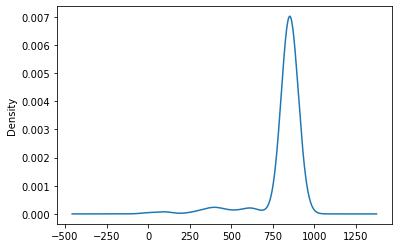

In [22]:
# Visualize the records counts for all locations. 
all_locations_recs.plot.density()

In [23]:
# Get the locations with less than 730 records.
low_rec_locations= {}
for key, value in all_locations_recs.items():
    if value < 730:
        location = {key: value}
        low_rec_locations.update(location)
print(f"There are {len(low_rec_locations)} locations with less than 730 daily records.")
print(f"These locations are: ")
low_rec_locations

There are 21 locations with less than 730 daily records.
These locations are: 


{'Saint Helena': 666,
 'Solomon Islands': 631,
 'Wallis and Futuna': 624,
 'Northern Mariana Islands': 610,
 'Vanuatu': 602,
 'Samoa': 594,
 'Micronesia (country)': 530,
 'Guernsey': 520,
 'Jersey': 470,
 'Tonga': 441,
 'Sint Maarten (Dutch part)': 414,
 'Kiribati': 413,
 'Cook Islands': 410,
 'Turkmenistan': 372,
 'Nauru': 369,
 'Tuvalu': 344,
 'Palau': 317,
 'Niue': 266,
 'Tokelau': 114,
 'Pitcairn': 85,
 'Western Sahara': 1}

In [24]:
# Bucket all locations with less than 2yrs of records into "other" bin.
for area in low_rec_locations:
    general_df.location = general_df.location.replace(area, "other")
# Check that binning was successful
general_df.location.value_counts()

other               8793
Mexico               916
Argentina            916
Thailand             913
Taiwan               901
                    ... 
Comoros              796
Tajikistan           795
Marshall Islands     789
Lesotho              783
North Korea          781
Name: location, Length: 210, dtype: int64

In [25]:
# Create a new DataFrame of locations with at least 2yr of records.
general_2yr_df = general_df[general_df.location != 'other']
print(general_2yr_df.shape)
general_2yr_df.head()

(178207, 51)


,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
id_row,,,,,,,,,,,,,,,,,,,,,
0,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [26]:
# Check successful filtering based on number of records for each location.
general_2yr_df.location.value_counts()

Mexico              916
Argentina           916
Thailand            913
Taiwan              901
United States       895
                   ... 
Comoros             796
Tajikistan          795
Marshall Islands    789
Lesotho             783
North Korea         781
Name: location, Length: 209, dtype: int64

#### Vaccinations Transformation

OWID notes:
- Vaccinations data were updated daily for 218 locations of the original dataset  (218/244).
- On 6 January 2021, we added two variables for daily vaccinations to our complete dataset.
- On 26 January 2021, we added 4 variables on people vaccinated and people fully vaccinated to our complete dataset.
- On 11 August 2021, we added the metric total_boosters to our vaccination data. This counts the total number of booster doses (doses administered beyond the number prescribed by the vaccination protocol).
- On 15 November 2021, we added the metrics new_people_vaccinated_smoothed and new_people_vaccinated_smoothed_per_hundred to our vaccination data. They count the daily number of people receiving their first vaccine dose.
- Since 29 March 2022, vaccination data is no longer updated on a daily basis. Updates now are only on weekdays (Monday until Friday).

We fill the vaccinations nulls with zeros because the absence of vaccines emphasizes certain trends in the pandemic and hence theiry initiation is expected to decrease the number of cases and covid-related deaths. 

###### We presume that vaccination  have played an integral role in the COVID-19 pandemic trajectory, and its influence may be observed over both cases and deaths.

In [27]:
# Create a new DataFrame of countries with vaccination data.
vaccination_df = general_2yr_df.loc[general_2yr_df.total_vaccinations.notnull()]
print(vaccination_df.shape)
vaccination_df.head()

(47620, 51)


,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
id_row,,,,,,,,,,,,,,,,,,,,,
364,Afghanistan,2021-02-22,55617.0,13.0,14.714,2433.0,1.0,0.857,1396.169,0.326,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
370,Afghanistan,2021-02-28,55714.0,7.0,15.714,2443.0,0.0,1.571,1398.604,0.176,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
386,Afghanistan,2021-03-16,55995.0,10.0,17.000,2460.0,1.0,1.286,1405.658,0.251,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
408,Afghanistan,2021-04-07,56873.0,94.0,59.857,2512.0,0.0,4.000,1427.699,2.360,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
423,Afghanistan,2021-04-22,58312.0,98.0,111.143,2561.0,4.0,4.000,1463.823,2.460,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


**There are 47,620 records of vaccinations from all locations.**

In [28]:
# Check the list of locations 
vaccination_df.location.nunique()

201

**There are 201 locations with vaccinations data.**

In [29]:
# Check the count of vaccinations per location
vaccination_df.location.value_counts()

Norway                             570
Denmark                            567
Canada                             564
Israel                             563
United States                      563
                                  ... 
Bosnia and Herzegovina              20
Tanzania                            17
Lesotho                             17
Falkland Islands                     6
Bonaire Sint Eustatius and Saba      2
Name: location, Length: 201, dtype: int64

In [30]:
# Check the first date of vaccination on record.
vaccination_df.date.sort_values()

id_row
134855    2020-12-02
98744     2020-12-04
98747     2020-12-07
134861    2020-12-08
47632     2020-12-08
             ...    
138049    2022-07-04
148728    2022-07-04
70516     2022-07-04
12967     2022-07-04
175006    2022-07-04
Name: date, Length: 47620, dtype: object

**The earliest time for vaccinations in the data is December 2nd, 2020.**

We will investigate whether the daily new and total vaccinations numbers are affected after March 29, 2022.

In [31]:
vac_df = general_2yr_df[['location', 'date', 'new_cases', 'total_cases', 'new_vaccinations','total_vaccinations', 'people_fully_vaccinated']]
vac_df.tail(20)

,location,date,new_cases,total_cases,new_vaccinations,total_vaccinations,people_fully_vaccinated
id_row,,,,,,,
198826,Zimbabwe,2022-06-15,232.0,254387.0,7481.0,11866991.0,4567466.0
198827,Zimbabwe,2022-06-16,115.0,254502.0,7126.0,11874117.0,4570349.0
198828,Zimbabwe,2022-06-17,251.0,254753.0,11967.0,11886084.0,4575674.0
198829,Zimbabwe,2022-06-18,0.0,254753.0,3295.0,11889379.0,4576849.0
198830,Zimbabwe,2022-06-19,48.0,254801.0,6250.0,11895629.0,4578232.0
198831,Zimbabwe,2022-06-20,30.0,254831.0,NaN,NaN,NaN
198832,Zimbabwe,2022-06-21,88.0,254919.0,NaN,11910337.0,4583367.0
198833,Zimbabwe,2022-06-22,130.0,255049.0,11366.0,11921703.0,4588340.0
198834,Zimbabwe,2022-06-23,87.0,255136.0,7628.0,11929331.0,4591475.0


In [32]:
us_vac_df = general_2yr_df.loc[general_2yr_df['location'] == 'United States']
us = us_vac_df[['location', 'date', 'new_cases', 'total_cases', 'new_vaccinations','total_vaccinations', 'people_fully_vaccinated']]
us.tail(20)

,location,date,new_cases,total_cases,new_vaccinations,total_vaccinations,people_fully_vaccinated
id_row,,,,,,,
188225,United States,2022-06-15,184905.0,86031984.0,274522.0,593872178.0,221991405.0
188226,United States,2022-06-16,130123.0,86162107.0,270923.0,594143101.0,222023745.0
188227,United States,2022-06-17,139238.0,86301345.0,287979.0,594431080.0,222059017.0
188228,United States,2022-06-18,16295.0,86317640.0,127802.0,594558882.0,222076416.0
188229,United States,2022-06-19,9900.0,86327540.0,60975.0,594619857.0,222085264.0
188230,United States,2022-06-20,93568.0,86421108.0,225463.0,594845320.0,222110248.0
188231,United States,2022-06-21,114642.0,86535750.0,246070.0,595091390.0,222140177.0
188232,United States,2022-06-22,184065.0,86719815.0,251782.0,595343172.0,222170345.0
188233,United States,2022-06-23,148157.0,86867972.0,250826.0,595593998.0,222198722.0


**The change in vaccinations reporting frequency from daily to weekdays only does seem to have affected the daily numbers in the dataset in certain locations.**

1. **We will shorten the window of analysis up until the reporting change took effect (March 29th, 2022).**
2. **Then, we will replace all the vaccinations with null values to zero because it indicates the absence of vaccinations and its affect on the spread of COVID-19.**

In [33]:
# Convert the 'date' column to a datetime.
general_2yr_df['date'] = general_2yr_df['date'].apply(pd.to_datetime)
print(general_2yr_df.date.dtype)

datetime64[ns]


In [34]:
# Create a DataFrame before march 29, 2022
mar_general_2yr_df = general_2yr_df.copy()
mar_general_2yr_df = mar_general_2yr_df.loc[mar_general_2yr_df['date'] < '2022-03-29']
print(mar_general_2yr_df.shape)
mar_general_2yr_df.head()

(157815, 51)


,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
id_row,,,,,,,,,,,,,,,,,,,,,
0,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [35]:
mar_general_2yr_df.location.value_counts()

Mexico              818
Argentina           818
Thailand            815
Taiwan              803
United States       797
                   ... 
Yemen               718
Comoros             698
Tajikistan          697
Marshall Islands    691
Lesotho             685
Name: location, Length: 209, dtype: int64

In [36]:
mar_general_2yr_df.date.sort_values()

id_row
115431   2020-01-01
6822     2020-01-01
115432   2020-01-02
6823     2020-01-02
6824     2020-01-03
            ...    
142506   2022-03-28
143393   2022-03-28
31514    2022-03-28
33245    2022-03-28
198747   2022-03-28
Name: date, Length: 157815, dtype: datetime64[ns]

In [37]:
mar_general_2yr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157815 entries, 0 to 198747
Data columns (total 51 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   location                                    157815 non-null  object        
 1   date                                        157815 non-null  datetime64[ns]
 2   total_cases                                 154214 non-null  float64       
 3   new_cases                                   154095 non-null  float64       
 4   new_cases_smoothed                          153041 non-null  float64       
 5   total_deaths                                139571 non-null  float64       
 6   new_deaths                                  139426 non-null  float64       
 7   new_deaths_smoothed                         138385 non-null  float64       
 8   total_cases_per_million                     154214 non-null  float64      

In [ ]:
# general_2yr_df['total_vaccinations'] = general_2yr_df['total_vaccinations'].fillna(0)
# general_2yr_df[['total_vaccinations']]

In [ ]:
# start with the vaccinations dataframe where all locations have total_vaccinations records
# Create a function that iterates through each location and 
# check the last date for the location then go to 
# check if total_vaccinations is null o
# if date of null vaccinations is > date of nonnull vaccinations then drop row 

# for each location, look at the total_vaccination value
# if total_vaccinations = nan and covid_days =0 
# then fillna total_vaccinations with 0 
# if covid_days >0 then 
# if total_vaccinations of the row above is 0 
# then fillna total_vaccinations with 0 
# else fillna total_vaccinations with 'N'

# then drop from dataframe all total_vaccinations = 'N'